In [1]:
# import 
import numpy as np
import random
from proglearn.sims import generate_gaussian_parity
import matplotlib.pyplot as plt

# k sample testing from hyppo
from hyppo.ksample import KSample
from hyppo.tools import rot_ksamp

from proglearn.forest import LifelongClassificationForest, UncertaintyForest
from proglearn.sims import *
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from math import log2, ceil
from joblib import Parallel, delayed
import seaborn as sns

In [2]:
task1_sample = 100
task2_sample = 100
mc_rep = 1000
angle_sweep = range(0,90,1)

In [3]:
def bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep):
    mean_te = np.zeros(len(angle_sweep), dtype=float)
    mean_error = np.zeros([len(angle_sweep), 6], dtype=float)
    for ii, angle in enumerate(angle_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=0)(
                delayed(experiment)(
                    task1_sample,
                    task2_sample,
                    task2_angle=angle * np.pi / 180,
                    max_depth=ceil(log2(task1_sample)),
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_error[ii] = np.mean(error, axis=0)
    return mean_te, mean_error

In [4]:
def experiment(
    n_task1,
    n_task2,
    n_test=1000,
    task1_angle=0,
    task2_angle=np.pi / 2,
    n_trees=10,
    max_depth=None,
    random_state=None,
):

    """
    A function to do Odif experiment between two tasks
    where the task data is generated using Gaussian parity.
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.
    n_trees : int, optional (default=10)
        Number of total trees to train for each task.
    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive UF error task1,
        naive UF task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
    uf1 = LifelongClassificationForest(default_n_estimators=n_trees)
    naive_uf = LifelongClassificationForest(default_n_estimators=n_trees)
    uf2 = LifelongClassificationForest(default_n_estimators=n_trees)

    # source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(
        n_test, angle_params=task1_angle
    )

    # target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(
        n_test, angle_params=task2_angle
    )

    if n_task1 == 0:
        progressive_learner.add_task(X_task2, y_task2, n_estimators=n_trees)
        uf2.add_task(X_task2, y_task2, n_estimators=n_trees)

        errors[0] = 0.5
        errors[1] = 0.5

        uf_task2 = uf2.predict(test_task2, task_id=0)
        l2f_task2 = progressive_learner.predict(test_task2, task_id=0)

        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)

        errors[4] = 0.5
        errors[5] = 1 - np.mean(uf_task2 == test_label_task2)
    elif n_task2 == 0:
        progressive_learner.add_task(X_task1, y_task1, n_estimators=n_trees)
        uf1.add_task(X_task1, y_task1, n_estimators=n_trees)

        uf_task1 = uf1.predict(test_task1, task_id=0)
        l2f_task1 = progressive_learner.predict(test_task1, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

        errors[2] = 0.5
        errors[3] = 0.5

        errors[4] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        progressive_learner.add_task(X_task1, y_task1, n_estimators=n_trees)
        progressive_learner.add_task(X_task2, y_task2, n_estimators=n_trees)

        uf1.add_task(X_task1, y_task1, n_estimators=2 * n_trees)
        uf2.add_task(X_task2, y_task2, n_estimators=2 * n_trees)

        naive_uf_train_x = np.concatenate((X_task1, X_task2), axis=0)
        naive_uf_train_y = np.concatenate((y_task1, y_task2), axis=0)
        naive_uf.add_task(naive_uf_train_x, naive_uf_train_y, n_estimators=n_trees)

        uf_task1 = uf1.predict(test_task1, task_id=0)
        l2f_task1 = progressive_learner.predict(test_task1, task_id=0)
        uf_task2 = uf2.predict(test_task2, task_id=0)
        l2f_task2 = progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(test_task1, task_id=0)
        naive_uf_task2 = naive_uf.predict(test_task2, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)
        errors[4] = 1 - np.mean(naive_uf_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_uf_task2 == test_label_task2)

    return errors

In [5]:
mean_te, mean_error = bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)

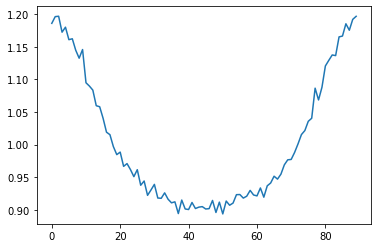

In [6]:
# plot bte directly
plt.plot(angle_sweep, mean_te) 

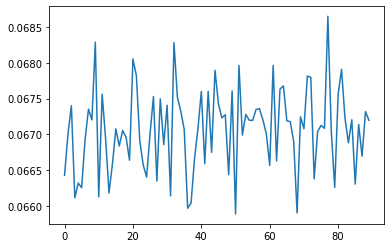

In [7]:
# single task error task1
plt.plot(angle_sweep, mean_error[:,0])

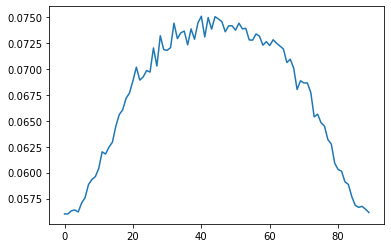

In [8]:
#  multitask error task1
plt.plot(angle_sweep, mean_error[:,1])

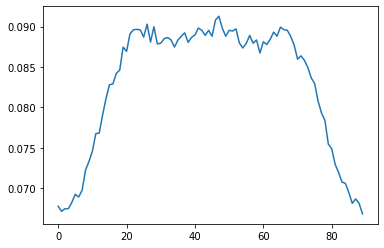

In [9]:
# single task error task2
plt.plot(angle_sweep, mean_error[:,2])

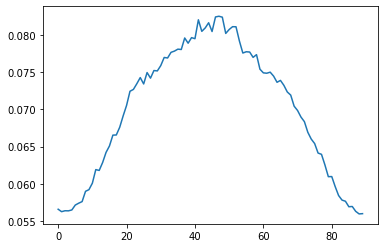

In [10]:
# multitask error task2
plt.plot(angle_sweep, mean_error[:,3])

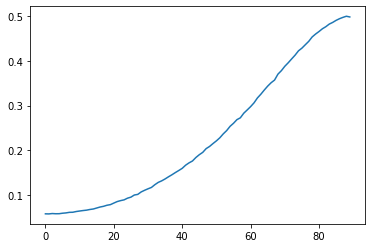

In [11]:
# naive UF error task1
plt.plot(angle_sweep, mean_error[:,4])

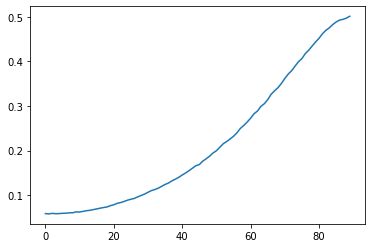

In [12]:
# naive UF task2
plt.plot(angle_sweep, mean_error[:,5])

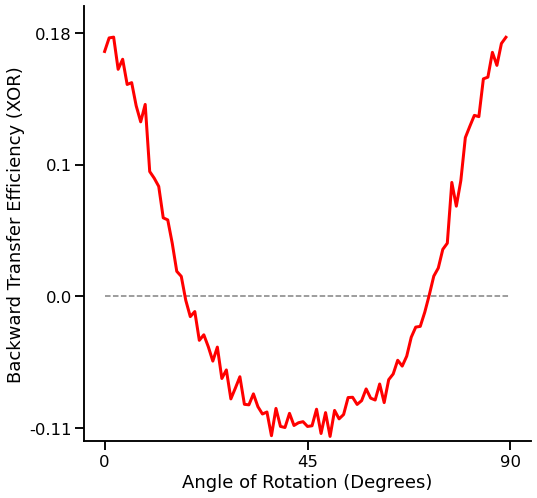

In [13]:
# plot bte using function from example
def plot_bte_v_angle(mean_te):
    angle_sweep = range(0, 90, 1)

    sns.set_context("talk")
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.plot(angle_sweep, mean_te, linewidth=3, c="r")
    ax.set_xticks([0, 45, 90])
    ax.set_xlabel("Angle of Rotation (Degrees)")
    ax.set_ylabel("Backward Transfer Efficiency (XOR)")
    ax.hlines(1, 0, 90, colors="gray", linestyles="dashed", linewidth=1.5)

    ax.set_yticks([0.9, 1, 1.1, 1.2])
    ax.set_ylim(0.89, 1.22)
    log_lbl = np.round(np.log([0.9, 1, 1.1, 1.2]), 2)
    labels = [item.get_text() for item in ax.get_yticklabels()]

    for ii, _ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])

    ax.set_yticklabels(labels)

    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    
plot_bte_v_angle(mean_te)

# Unaware

In [14]:
def unaware_experiment(
    n_task1,
    n_task2,
    n_test=1000,
    task1_angle=0,
    task2_angle=np.pi / 2,
    n_trees=10,
    max_depth=None,
    random_state=None,
):

    """
    A function to do Odif experiment between two tasks
    where the task data is generated using Gaussian parity.
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.
    n_trees : int, optional (default=10)
        Number of total trees to train for each task.
    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive UF error task1,
        naive UF task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
    uf1 = LifelongClassificationForest(default_n_estimators=n_trees)
    naive_uf = LifelongClassificationForest(default_n_estimators=n_trees)
    uf2 = LifelongClassificationForest(default_n_estimators=n_trees)

    # source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(
        n_test, angle_params=task1_angle
    )

    # target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(
        n_test, angle_params=task2_angle
    )

    if KSample(indep_test="Dcorr").test(X_task1, X_task2)[1] <= 0.05:
        progressive_learner.add_task(X_task1, y_task1, n_estimators=n_trees)
        progressive_learner.add_task(X_task2, y_task2, n_estimators=n_trees)

        uf1.add_task(X_task1, y_task1, n_estimators=2 * n_trees)
        uf2.add_task(X_task2, y_task2, n_estimators=2 * n_trees)

        naive_uf_train_x = np.concatenate((X_task1, X_task2), axis=0)
        naive_uf_train_y = np.concatenate((y_task1, y_task2), axis=0)
        naive_uf.add_task(naive_uf_train_x, naive_uf_train_y, n_estimators=n_trees)

        uf_task1 = uf1.predict(test_task1, task_id=0)
        l2f_task1 = progressive_learner.predict(test_task1, task_id=0)
        uf_task2 = uf2.predict(test_task2, task_id=0)
        l2f_task2 = progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(test_task1, task_id=0)
        naive_uf_task2 = naive_uf.predict(test_task2, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)
        errors[4] = 1 - np.mean(naive_uf_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_uf_task2 == test_label_task2)
    else:
        naive_uf_train_x = np.concatenate((X_task1, X_task2), axis=0)
        naive_uf_train_y = np.concatenate((y_task1, y_task2), axis=0)
        progressive_learner.add_task(naive_uf_train_x, naive_uf_train_y, n_estimators=n_trees)

        uf1.add_task(X_task1, y_task1, n_estimators=2 * n_trees)
        uf2.add_task(X_task2, y_task2, n_estimators=2 * n_trees)


        naive_uf.add_task(naive_uf_train_x, naive_uf_train_y, n_estimators=n_trees)

        uf_task1 = uf1.predict(test_task1, task_id=0)
        l2f_task1 = progressive_learner.predict(test_task1, task_id=0)
        uf_task2 = uf2.predict(test_task2, task_id=0)
        # l2f_task2 = progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(test_task1, task_id=0)
        naive_uf_task2 = naive_uf.predict(test_task2, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 0
        errors[4] = 1 - np.mean(naive_uf_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_uf_task2 == test_label_task2)

    return errors

In [15]:
def unaware_bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep):
    mean_te = np.zeros(len(angle_sweep), dtype=float)
    mean_error = np.zeros([len(angle_sweep), 6], dtype=float)
    for ii, angle in enumerate(angle_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=0)(
                delayed(unaware_experiment)(
                    task1_sample,
                    task2_sample,
                    task2_angle=angle * np.pi / 180,
                    max_depth=ceil(log2(task1_sample)),
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_error[ii] = np.mean(error, axis=0)
    return mean_te, mean_error

In [16]:
mc_rep = 1000
mean_te, mean_error = unaware_bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)

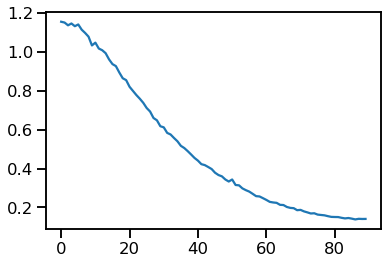

In [17]:
plt.plot(mean_te)

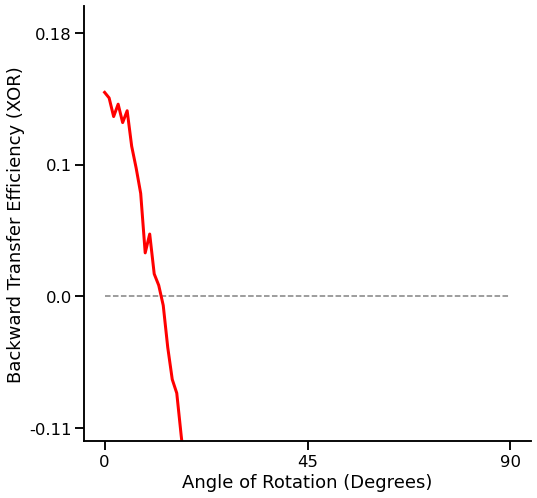

In [18]:
plot_bte_v_angle(mean_te)

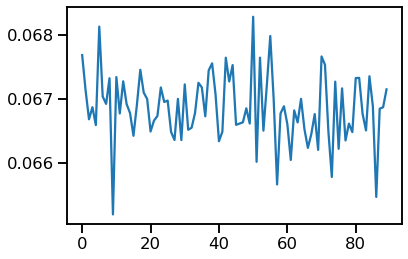

In [19]:
# single task error task1
plt.plot(angle_sweep, mean_error[:,0])

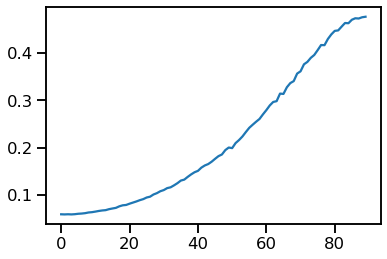

In [20]:
#  multitask error task1
plt.plot(angle_sweep, mean_error[:,1])

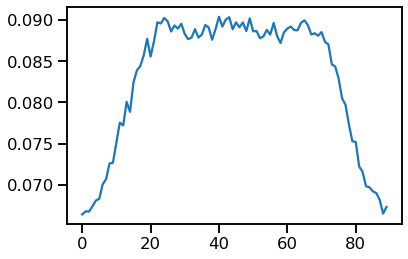

In [21]:
# single task error task2
plt.plot(angle_sweep, mean_error[:,2])

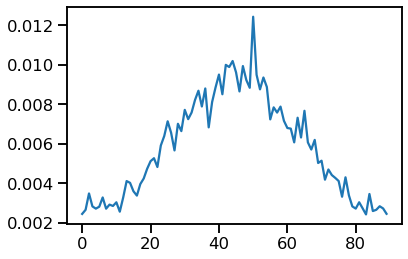

In [22]:
# multitask error task2
plt.plot(angle_sweep, mean_error[:,3])

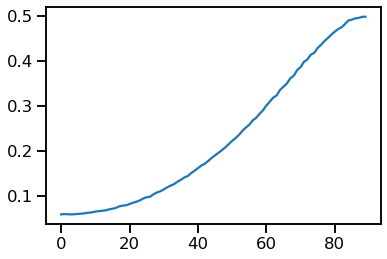

In [23]:
# naive UF error task1
plt.plot(angle_sweep, mean_error[:,4])

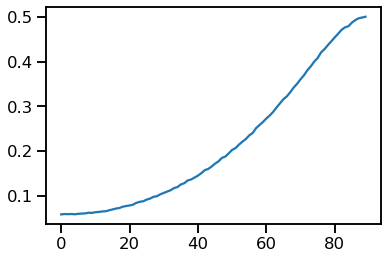

In [24]:
# naive UF task2
plt.plot(angle_sweep, mean_error[:,5])